<a href="https://colab.research.google.com/github/anilsah895/Fine-tuning-using-pretrained-convnet/blob/master/PreTrainedMobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##import necessary model


In [0]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model


from keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
from keras import optimizers

##loading the inception V3 weights


In [118]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
   -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5



from livelossplot import PlotLossesKeras   
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
#local_weights_file=os.path.join("content/drive/My Drive/Colab Notebooks/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2019-06-15 08:25:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   192MB/s    in 0.4s    

2019-06-15 08:25:07 (192 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 150, 150, 3) 0                               

In [75]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

('last layer output shape: ', (None, 7, 7, 768))


In [0]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [0]:
Base_dir="gdrive/My Drive/Colab Notebooks/Skin_Data/"
train_path = Base_dir+"train"
validation_path = Base_dir+"validation"
train_path = Base_dir+"train"
validation_path = Base_dir+"validation"

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (10, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

with open("MODEL_SUMMARY_FILE.text","w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264
#content/drive/My Drive/Colab Notebooks/Skin_Data/model_summary.txt
#content/drive/My Drive/Colab Notebooks/Skin_Data/model_summary.txt

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [91]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [97]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   #shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_path,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))


Found 7016 images belonging to 10 classes.
Found 1793 images belonging to 10 classes.


In [98]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
callbacks1 = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 50,
            verbose = 1,
            callbacks=[callbacks1])

Epoch 1/10
100/100 [==============================] - 817s 8s/step - loss: 2.1780 - acc: 0.2370 - val_loss: 2.1640 - val_acc: 0.3120
Epoch 2/10
100/100 [==============================] - 476s 5s/step - loss: 2.0437 - acc: 0.2865 - val_loss: 2.6097 - val_acc: 0.3170
Epoch 3/10
100/100 [==============================] - 508s 5s/step - loss: 1.9391 - acc: 0.3250 - val_loss: 2.4999 - val_acc: 0.3550
Epoch 4/10
100/100 [==============================] - 261s 3s/step - loss: 1.9019 - acc: 0.3532 - val_loss: 2.6525 - val_acc: 0.3570
Epoch 5/10
100/100 [==============================] - 32s 315ms/step - loss: 1.8934 - acc: 0.3470 - val_loss: 3.0678 - val_acc: 0.3220
Epoch 6/10
100/100 [==============================] - 32s 316ms/step - loss: 1.8846 - acc: 0.3642 - val_loss: 3.0638 - val_acc: 0.3520
Epoch 7/10
100/100 [==============================] - 31s 305ms/step - loss: 1.8649 - acc: 0.3675 - val_loss: 3.0679 - val_acc: 0.3560
Epoch 8/10
100/100 [==============================] - 33s 334ms

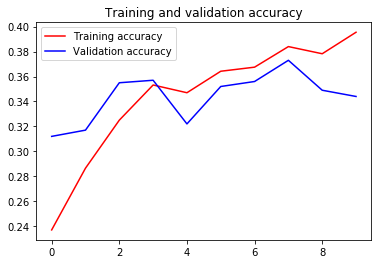

<Figure size 432x288 with 0 Axes>

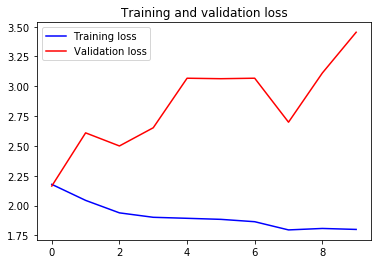

In [100]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.savefig("TRAINING_PLOT_FILE.png", bbox_inches='tight')
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("VALIDATION_PLOT_FILE.png", bbox_inches='tight')

#files.download(MODEL_FILE)
#files.download(TRAINING_LOGS_FILE)
files.download("VALIDATION_PLOT_FILE.png")
files.download("TRAINING_PLOT_FILE.png")
#files.download(SUBMISSION_FILE)

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
# Drawing plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig("TRAINING_PLOT_FILE.png", bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig("VALIDATION_PLOT_FILE.png", bbox_inches='tight')
plt.close()


#
#files.download(MODEL_FILE)
#files.download(TRAINING_LOGS_FILE)
files.download("VALIDATION_PLOT_FILE.png")
files.download("TRAINING_PLOT_FILE.png")
#files.download(SUBMISSION_FILE)

In [0]:

files.download("MODEL_SUMMARY_FILE.text")

In [0]:

pre_trained_model.trainable = True

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'mixed9_1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [123]:
callbacks1 = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 50,
            verbose = 1,
            callbacks=[callbacks1])

Epoch 1/10
100/100 [==============================] - 34s 342ms/step - loss: 1.7736 - acc: 0.3960 - val_loss: 2.7574 - val_acc: 0.3740
Epoch 2/10
100/100 [==============================] - 32s 317ms/step - loss: 1.7615 - acc: 0.4100 - val_loss: 3.0251 - val_acc: 0.3510
Epoch 3/10
100/100 [==============================] - 32s 318ms/step - loss: 1.7763 - acc: 0.3970 - val_loss: 2.8280 - val_acc: 0.3720
Epoch 4/10
100/100 [==============================] - 32s 318ms/step - loss: 1.7586 - acc: 0.4001 - val_loss: 2.9125 - val_acc: 0.3820
Epoch 5/10
100/100 [==============================] - 32s 320ms/step - loss: 1.7366 - acc: 0.4090 - val_loss: 3.0121 - val_acc: 0.3630
Epoch 6/10
100/100 [==============================] - 32s 320ms/step - loss: 1.7757 - acc: 0.4020 - val_loss: 3.0838 - val_acc: 0.3730
Epoch 7/10
100/100 [==============================] - 31s 308ms/step - loss: 1.7199 - acc: 0.4065 - val_loss: 2.9598 - val_acc: 0.3760
Epoch 8/10
100/100 [==============================] - 3

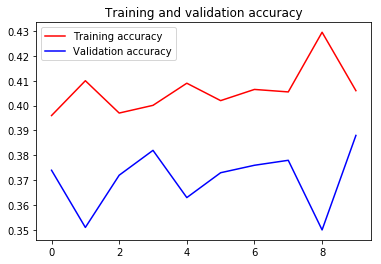

<Figure size 432x288 with 0 Axes>

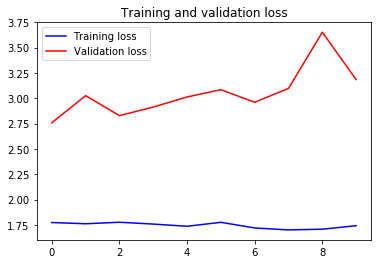

In [124]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.savefig("TRAINING_PLOT_FILE.png", bbox_inches='tight')
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("VALIDATION_PLOT_FILE.png", bbox_inches='tight')
#plt.close()


#
#files.download(MODEL_FILE)
#files.download(TRAINING_LOGS_FILE)
files.download("VALIDATION_PLOT_FILE.png")
files.download("TRAINING_PLOT_FILE.png")
#files.download(SUBMISSION_FILE)

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)